# Elo Merchant Category Recommendation - LynxKite feature boosting and LightGBM with StratifiedKFold
End date: _2019. february 19._<br/>

This tutorial notebook is part of a series for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. LynxKite does not yet support some of the data preprocessing, thus they need to be done in Python. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

Inspired by [Feature engineering](https://github.com/zzsza/Play-Kaggle/blob/master/Elo-Merchant-Category-Recommendation/notebooks/03.Feature-Engineering.ipynb)

In [47]:
import gc
import random
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score

warnings.filterwarnings("ignore")

random.seed(402)

In [48]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Feature engineering
Inspired by [Feature Engineering](https://github.com/zzsza/Play-Kaggle/blob/master/Elo-Merchant-Category-Recommendation/notebooks/04.Feature-Engineering_2nd.ipynb)

### Train & test data

In [49]:
df_train = pd.read_csv("input/train.csv", parse_dates=["first_active_month"])
df_train = reduce_mem_usage(df_train)
print("{:,} observations and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))

Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)
201,917 observations and 6 features in train set.


In [50]:
df_test = pd.read_csv("input/test.csv", parse_dates=["first_active_month"])
df_test = reduce_mem_usage(df_test)
print("{:,} observations and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)
123,623 observations and 5 features in test set.


In [51]:
df_train['first_active_month'] = pd.to_datetime(df_train['first_active_month'])
df_train['elapsed_days'] = (datetime.date(2018, 2, 1) - df_train['first_active_month'].dt.date).dt.days

In [52]:
df_test['first_active_month'] = pd.to_datetime(df_test['first_active_month'])
df_test['elapsed_days'] = (datetime.date(2018, 2, 1) - df_test['first_active_month'].dt.date).dt.days

### Transactions

In [ ]:
%%time
df_hist_trans = pd.read_csv('input/historical_transactions.csv', parse_dates=['purchase_date'])
df_hist_trans = reduce_mem_usage(df_hist_trans)
print('Number of historical transactions: {:,}'.format(len(df_hist_trans)))

In [ ]:
%%time
df_new_trans = pd.read_csv('input/new_merchant_transactions.csv', parse_dates=['purchase_date'])
df_new_trans = reduce_mem_usage(df_new_trans)
print('Number of new transactions: {:,}'.format(len(df_new_trans)))

In [ ]:
df_new_trans.isna().sum()

Missing data handling (why these values?)

In [ ]:
for df in [df_hist_trans, df_new_trans]:
    df['category_2'].fillna(1.0, inplace=True)
    df['category_3'].fillna('A', inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a', inplace=True)

Date handling

In [ ]:
def create_date_features(df, source_column, preposition):
    df[preposition + '_year'] = df[source_column].dt.year
    df[preposition + '_month'] = df[source_column].dt.month
    df[preposition + '_day'] = df[source_column].dt.day
    df[preposition + '_hour'] = df[source_column].dt.hour
    df[preposition + '_weekofyear'] = df[source_column].dt.weekofyear
    df[preposition + '_dayofweek'] = df[source_column].dt.dayofweek
    df[preposition + '_weekend'] = (df[source_column].dt.weekday >=5).astype(int)
    df[preposition + '_quarter'] = df[source_column].dt.quarter
    
    return df

In [ ]:
df_hist_trans['authorized_flag'] = df_hist_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_hist_trans['category_1'] = df_hist_trans['category_1'].map({'N': 0, 'Y': 1})

df_hist_trans['purchase_date'] = pd.to_datetime(df_hist_trans['purchase_date'])
df_hist_trans = create_date_features(df_hist_trans, 'purchase_date', 'purchase')

In [ ]:
df_new_trans['authorized_flag'] = df_new_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_new_trans['category_1'] = df_new_trans['category_1'].map({'N': 0, 'Y': 1})

df_new_trans['purchase_date'] = pd.to_datetime(df_new_trans['purchase_date'])
df_new_trans = create_date_features(df_new_trans, 'purchase_date', 'purchase')

In [ ]:
df_hist_trans['month_diff'] = ((datetime.date(2018, 12, 1) - df_hist_trans['purchase_date'].dt.date).dt.days)//30
df_hist_trans['month_diff'] += df_hist_trans['month_lag']

In [ ]:
df_new_trans['month_diff'] = ((datetime.date(2018, 12, 1) - df_new_trans['purchase_date'].dt.date).dt.days)//30
df_new_trans['month_diff'] += df_new_trans['month_lag']

In [ ]:
df_hist_trans = reduce_mem_usage(df_hist_trans)

In [ ]:
df_new_trans = reduce_mem_usage(df_new_trans)

#### Aggregation

In [18]:
def aggregate_transactions(df, prefix):
    agg_funcs = {
        'authorized_flag': ['sum', 'mean'],

        'card_id': ['size'],
        'category_1': ['sum', 'mean'],
        
        'installments': ['sum', 'max', 'min', 'mean', 'var'],

        'merchant_category_id': ['nunique'],
        'merchant_id': ['nunique'],
        'month_diff': ['mean'],
        'month_lag': ['max','min','mean','var'],

        'purchase_amount': ['sum', 'max', 'min', 'mean', 'var'],
        'purchase_date': ['max', 'min'],
        'purchase_dayofweek': ['nunique'],
        'purchase_hour': ['nunique'],
        'purchase_month': ['nunique'],
        'purchase_year': ['nunique'],
        'purchase_weekend': ['sum', 'mean'],
        'purchase_weekofyear': ['nunique'],

        'subsector_id': ['nunique']
    }

    df['category_2_mean'] = df.groupby(['category_2'])['purchase_amount'].transform('mean')
    df['category_3_mean'] = df.groupby(['category_3'])['purchase_amount'].transform('mean')

    df_agg = df.groupby('card_id').agg(agg_funcs)
    df_agg.columns = [prefix + '_' + '_'.join(col).strip() for col in df_agg.columns.values]
    df_agg.reset_index(drop=False, inplace=True)
    df_agg[prefix + '_purchase_date_diff'] = (df_agg[prefix + '_purchase_date_max'] - df_agg[prefix + '_purchase_date_min']).dt.days
    df_agg[prefix + '_purchase_date_average'] = df_agg[prefix + '_purchase_date_diff']/df_agg[prefix + '_card_id_size']
    df_agg[prefix + '_purchase_date_uptonow'] = (datetime.datetime.today() - df_agg[prefix + '_purchase_date_max']).dt.days

    df = (df_agg.groupby('card_id').size().reset_index(name='{}_transactions_count'.format(prefix)))
    df_agg = pd.merge(df, df_agg, on='card_id', how='left')
    return df_agg

In [25]:
df_hist_agg = aggregate_transactions(df_hist_trans, 'hist')
df_new_agg = aggregate_transactions(df_new_trans, 'new')

df_train = df_train.merge(df_hist_agg, on='card_id', how='left')
df_train = df_train.merge(df_new_agg, on='card_id', how='left')

df_test = df_test.merge(df_hist_agg, on='card_id', how='left')
df_test = df_test.merge(df_new_agg, on='card_id', how='left')

In [26]:
df_hist_agg[:3]

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_card_id_size,hist_category_1_sum,hist_category_1_mean,hist_installments_sum,hist_installments_max,hist_installments_min,...,hist_purchase_hour_nunique,hist_purchase_month_nunique,hist_purchase_year_nunique,hist_purchase_weekend_sum,hist_purchase_weekend_mean,hist_purchase_weekofyear_nunique,hist_subsector_id_nunique,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow
0,C_ID_00007093c1,1,114.0,0.765101,149,28.0,0.187919,192,6,1,...,18,12,2,25.0,0.167785,39,13,377,2.530201,361
1,C_ID_0001238066,1,120.0,0.975610,123,2.0,0.016260,198,10,-1,...,20,6,2,52.0,0.422764,23,17,151,1.227642,360
2,C_ID_0001506ef0,1,62.0,0.939394,66,0.0,0.000000,1,1,0,...,15,11,2,32.0,0.484848,24,12,398,6.030303,371


In [27]:
del df_hist_trans, df_new_trans, df_hist_agg, df_new_agg
gc.collect()

273

In [28]:
df_train['hist_first_buy'] = (df_train['hist_purchase_date_min'] - df_train['first_active_month']).dt.days
df_train['new_first_buy'] = (df_train['new_purchase_date_min'] - df_train['first_active_month']).dt.days

df_test['hist_first_buy'] = (df_test['hist_purchase_date_min'] - df_test['first_active_month']).dt.days
df_test['new_first_buy'] = (df_test['new_purchase_date_min'] - df_test['first_active_month']).dt.days

In [29]:
for f in ['hist_purchase_date_max', 'hist_purchase_date_min', 'new_purchase_date_max', 'new_purchase_date_min']:
    df_train[f] = df_train[f].astype(np.int64) * 1e-9
    df_test[f] = df_test[f].astype(np.int64) * 1e-9

df_train['card_id_total'] = df_train['hist_card_id_size'] + df_train['new_card_id_size']
df_test['card_id_total'] = df_test['hist_card_id_size'] + df_test['new_card_id_size']

df_train['purchase_amount_total'] = df_train['hist_purchase_amount_sum'] + df_train['new_purchase_amount_sum']
df_test['purchase_amount_total'] = df_test['hist_purchase_amount_sum'] + df_test['new_purchase_amount_sum']

In [30]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [31]:
for f in ['feature_1', 'feature_2', 'feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

### Loading possible outliers

In [34]:
df_train_po = pd.read_csv("preprocessed/possible_outliers_train_gt0.9.csv")
df_train_po = reduce_mem_usage(df_train_po)
print("{:,} observations and {} features in train set.".format(df_train_po.shape[0], df_train_po.shape[1]))

Starting memory usage:  3.08 MB
Reduced memory usage:  1.73 MB (43.7% reduction)
201,917 observations and 2 features in train set.


In [35]:
df_test_po = pd.read_csv("preprocessed/possible_outliers_test_gt0.9.csv")
df_test_po = reduce_mem_usage(df_test_po)
print("{:,} observations and {} features in train set.".format(df_test_po.shape[0], df_test_po.shape[1]))

Starting memory usage:  1.89 MB
Reduced memory usage:  1.06 MB (43.7% reduction)
123,623 observations and 2 features in train set.


In [37]:
len(df_train_po[df_train_po['possible_out'] == 1]), len(df_test_po[df_test_po['possible_out'] == 1])

(31039, 335)

In [38]:
df_train = df_train.merge(df_train_po, on='card_id', how='left')
df_test = df_test.merge(df_test_po, on='card_id', how='left')

In [39]:
df_train[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_days,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,...,new_subsector_id_nunique,new_purchase_date_diff,new_purchase_date_average,new_purchase_date_uptonow,hist_first_buy,new_first_buy,card_id_total,purchase_amount_total,outliers,possible_out
0,2017-06-01,C_ID_92a2005557,0.013145,0.008752,0.011428,-0.820312,245,1,247.0,0.950000,...,10.0,54.0,2.347826,300.0,26,277.0,283.0,-179.210922,0,0
1,2017-01-01,C_ID_3d0044924f,0.010712,0.011385,0.010283,0.392822,396,1,339.0,0.968571,...,4.0,56.0,9.333333,330.0,5,396.0,356.0,-214.361801,0,0
2,2016-08-01,C_ID_d639edf6cd,0.010610,0.008752,0.010283,0.687988,549,1,41.0,0.953488,...,1.0,0.0,0.000000,300.0,163,635.0,44.0,-29.867586,0,0


### Loading features from LynxKite

### Merging

### Training
[LightGBM parameter tuning](https://testlightgbm.readthedocs.io/en/latest/Parameters-tuning.html)<br/>
[What is LightGBM, How to implement it? How to fine tune the parameters?](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc)

In [40]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month', 'target', 'outliers']]
target = df_train['target']
del df_train['target']

In [41]:
%%time
param = {
    "bagging_freq": 1,
    "bagging_fraction": 0.9,
    "bagging_seed": 11,
    "boosting": "gbdt",

    "feature_fraction": 0.9,
    "feature_fraction_seed": 1,

    "lambda_l1": 0.1,
    #"lambda_l2": 0.001,
    "learning_rate": 0.01,

    #"max_bin": 5,
    'max_depth': -1,
    "metric": "rmse",
    "min_data_in_leaf": 30,
    #"min_gain_to_split": 0.1,
    #"min_sum_hessian_in_leaf": 1e-3,
    "min_child_samples": 20,
    #"num_iterations": 100,
    #"num_boost_round": 100,
    "num_leaves": 31,
    "nthread": -1,

    "objective": "regression",

    "random_state": 402,
    "verbosity": -1
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=402)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train, df_train['possible_out'].values)):
    print("\nFold {}.".format(fold_+1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits


Fold 1.
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.65386	valid_1's rmse: 3.77224
[200]	training's rmse: 3.57802	valid_1's rmse: 3.73927
[300]	training's rmse: 3.53122	valid_1's rmse: 3.72646
[400]	training's rmse: 3.49593	valid_1's rmse: 3.71873
[500]	training's rmse: 3.46719	valid_1's rmse: 3.71394
[600]	training's rmse: 3.44337	valid_1's rmse: 3.70946
[700]	training's rmse: 3.42077	valid_1's rmse: 3.70708
[800]	training's rmse: 3.40171	valid_1's rmse: 3.70496
[900]	training's rmse: 3.38239	valid_1's rmse: 3.70284
[1000]	training's rmse: 3.36466	valid_1's rmse: 3.70217
[1100]	training's rmse: 3.34893	valid_1's rmse: 3.70132
[1200]	training's rmse: 3.33356	valid_1's rmse: 3.70036
[1300]	training's rmse: 3.31809	valid_1's rmse: 3.6996
[1400]	training's rmse: 3.30427	valid_1's rmse: 3.69917
[1500]	training's rmse: 3.29016	valid_1's rmse: 3.69853
[1600]	training's rmse: 3.27568	valid_1's rmse: 3.6982
[1700]	training's rmse: 3.26122	valid_1's r

In [42]:
cv_score = np.sqrt(mean_squared_error(oof, target))
print("CV score: {:.6f}".format(cv_score))

CV score: 3.654257


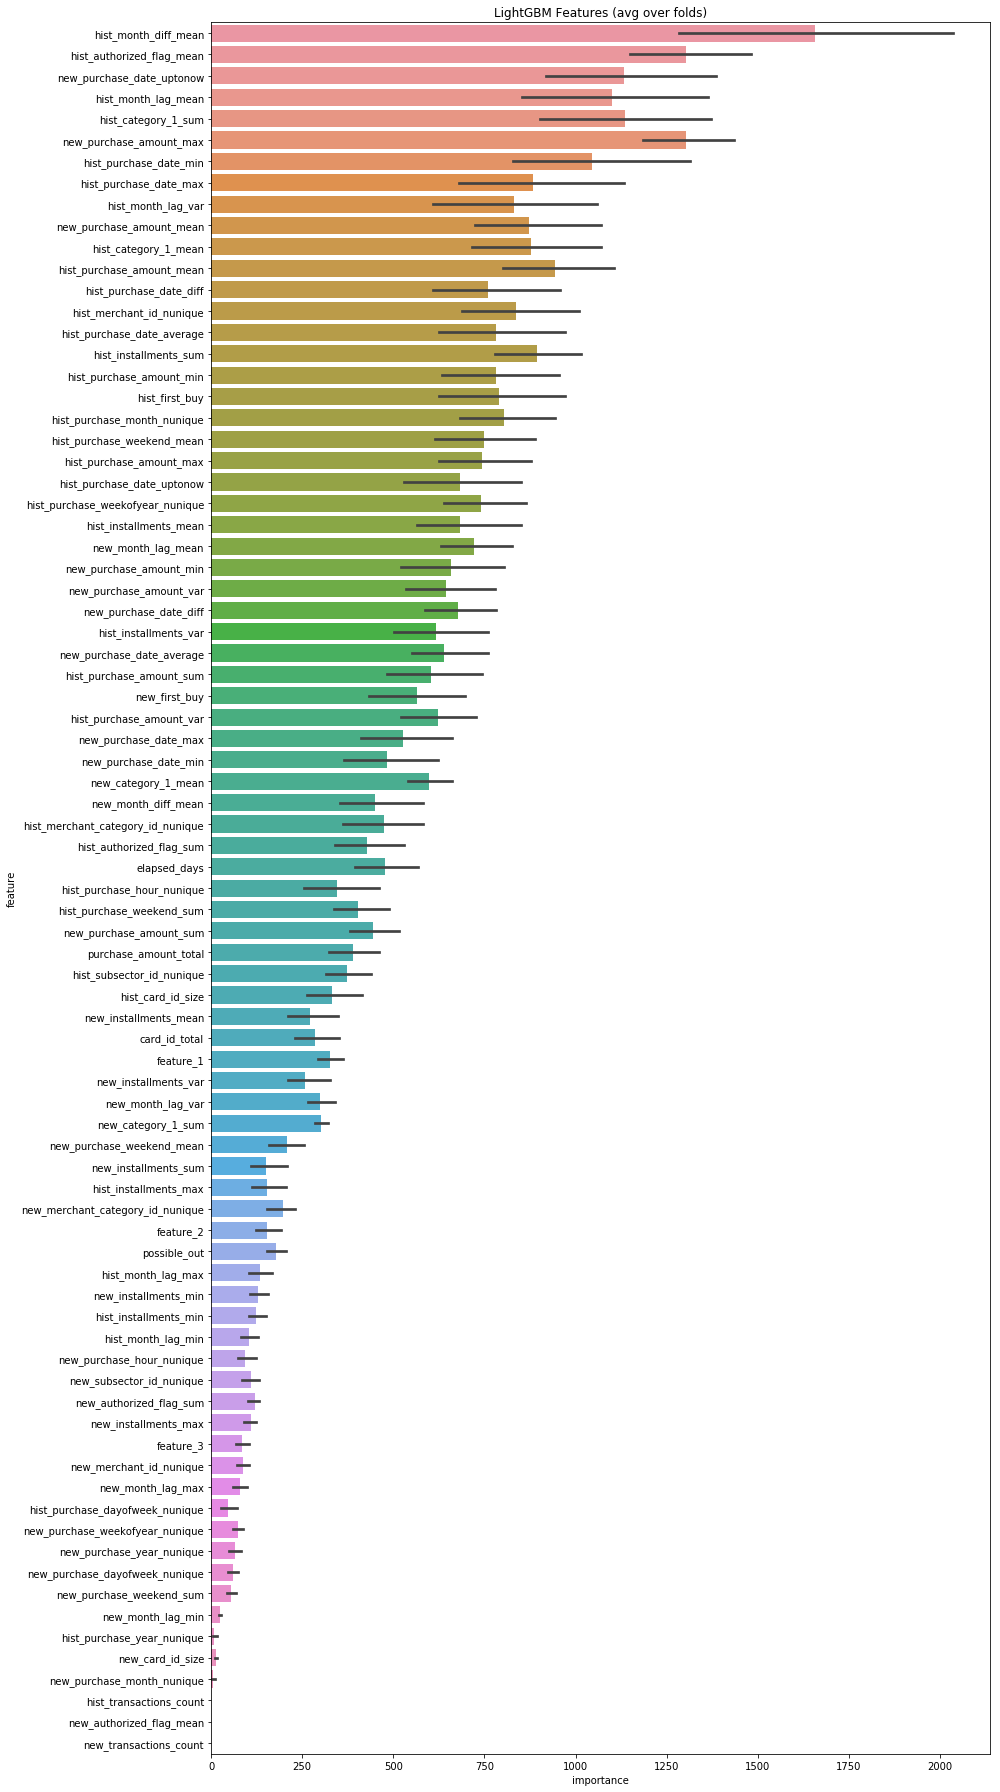

In [44]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14, 25))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [45]:
best_features[best_features['importance'] == 0]

,feature,importance,fold
4,hist_transactions_count,0,1
40,new_transactions_count,0,1
42,new_authorized_flag_mean,0,1
4,hist_transactions_count,0,2
40,new_transactions_count,0,2
42,new_authorized_flag_mean,0,2
4,hist_transactions_count,0,3
40,new_transactions_count,0,3
42,new_authorized_flag_mean,0,3
4,hist_transactions_count,0,4


In [46]:
sub_df = pd.DataFrame({
    "card_id": df_test["card_id"].values
})

sub_df["target"] = predictions
sub_df.to_csv("output/regression_with_lk_{:.6f}.csv".format(cv_score), index=False)

[Just Train Data - LGB & XGB & CatBoost w/ Blending](https://www.kaggle.com/silverstone1903/just-train-data-lgb-xgb-catboost-w-blending/data)<br/>
[MultiModel + RIDGE + STACKING](https://www.kaggle.com/ashishpatel26/rmse-3-66-multimodel-ridge-stacking)
https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/75935